In [1]:
import datetime
import calendar

from pycds import *
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
from sqlalchemy import and_, or_
from sqlalchemy.sql import func
from sqlalchemy import funcfilter
from sqlalchemy import within_group
from sqlalchemy import select

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pgpasslib

In [2]:
connection_string = "postgresql+psycopg2://nannau@dbmsc.pcic.uvic.ca/msc"
engine = create_engine(connection_string)
Session = sessionmaker(bind = engine)
session = Session()

/home/nannau/tri/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [3]:
year = 2000 
month = 7
day = 1
interval = 1
yr_interval = 5

start_year = datetime.datetime(year, month, day)
end_year = datetime.datetime(year + yr_interval, month, day)

start_time = datetime.datetime(year, month, day)
end_time = datetime.datetime(year, month + interval, day)

In [18]:
def baseline(start_time, end_time):
    query = session.query(Obs.datum, Obs.time, Variable.standard_name, History.station_id).filter(Obs.time <= end_time).filter(Obs.time >= start_time).join(History).join(Variable)
    return query

def precip_query(start_time, end_time):
    query = baseline(start_time, end_time).filter(Variable.standard_name == "lwe_thickness_of_precipitation_amount").filter(or_(Variable.description == "Total precipiation", Variable.id == 1397))
    return query

def temp_query(start_time, end_time):
    query = baseline(start_time, end_time).filter(Variable.standard_name == "air_temperature").filter(or_(Variable.description == "Air temperature", Variable.id == 1510))
    return query

def annual_rain(start_year, end_year, mean = True):
    yr_interval = float(np.abs(end_year.year - start_year.year))
    print(yr_interval)
    query = session.query(func.sum(Obs.datum*0.1/yr_interval).label("sum"), func.max(Obs.time).label("max_date"), History.lat, History.lon, History.station_id).group_by(History).having(func.max(Obs.time) >= end_year).filter(Variable.standard_name == "lwe_thickness_of_precipitation_amount").filter(or_(Variable.description == "Total precipiation", Variable.id == 1397))
    query = query.filter(Obs.time <= end_year).filter(Obs.time >= start_year).join(History).join(Variable)
    return query

def design_temp_25(start_time, end_time, month = 7):
    query = session.query(func.percentile_cont(0.025).within_group(
                    Obs.datum.asc()), 
                          func.min(Obs.time),
                          History.lat,
                          History.lon,
                          History.id).group_by(History) \
    .filter(Variable.standard_name == "air_temperature") \
    #.filter(or_(Variable.description == "Air temperature", Variable.id == 1510))
    query = query.filter(func.extract("month", Obs.time) == month)
    query = query.filter(func.extract("year", Obs.time) <= end_time.year).filter(func.extract("year", Obs.time) >= start_time.year).join(History).join(Variable)
    #percentiles = stations.get(func.percentile_disc(0.025).within_group(Obs.datum).label('percentile')).label('percentiles')
    # query = select([stations.Obs.time, percentiles.percentile]).order_by(stations.Obs.time)
    
    return query

def design_temp_1(start_time, end_time, month = 7):
    query = session.query(func.percentile_cont(0.01).within_group(
                    Obs.datum.asc()), 
                          func.min(Obs.time),
                          History.lat,
                          History.lon,
                          History.id).group_by(History) \
    .filter(Variable.standard_name == "air_temperature") \
    #.filter(or_(Variable.description == "Air temperature", Variable.id == 1510))
    query = query.filter(func.extract("month", Obs.time) == month)
    query = query.filter(func.extract("year", Obs.time) <= end_time.year).filter(func.extract("year", Obs.time) >= start_time.year).join(History).join(Variable)
    #percentiles = stations.get(func.percentile_disc(0.025).within_group(Obs.datum).label('percentile')).label('percentiles')
    # query = select([stations.Obs.time, percentiles.percentile]).order_by(stations.Obs.time)
    
    return query

def station_query(start_time, end_time):
    query = session.query()

def show_design_values():
    query = session.query(Variable.standard_name, Variable.description, Variable.unit, Variable.id)
    return query


In [19]:
q = design_temp_1(start_time, end_time)#.all()
q1 = design_temp_25(start_time, end_time)
#q = show_design_values()

In [20]:
df = pd.read_sql(q.statement, engine)
df1 =  pd.read_sql(q1.statement, engine)

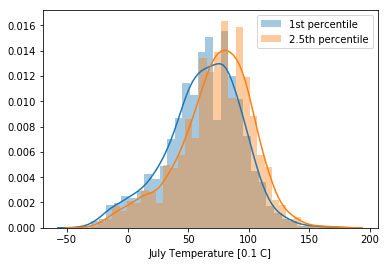

In [30]:
sns.distplot(df['anon_1'], label = "1st percentile")#.hist()
sns.distplot(df1['anon_1'], label = "2.5th percentile")
plt.xlabel("July Temperature [0.1 C]" )
plt.legend()
plt.savefig("july_air_temp_percentiles")
plt.show()

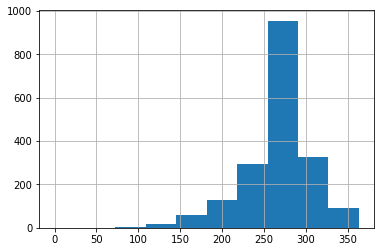

In [13]:
df['anon_1'].hist() 

In [ ]:
sns.distplot(df['datum'])
plt.xlabel('July Temperature [0.1 C]')
plt.ylabel('KDE Frequency')
plt.savefig('temp_percentile_25')

In [9]:
plt.scatter(df['lon'], df['lat'])
plt.ylim(45, 60)

KeyError: 'lon'